<a href="https://colab.research.google.com/github/Hali57/FUTURE_ML_01/blob/main/Task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

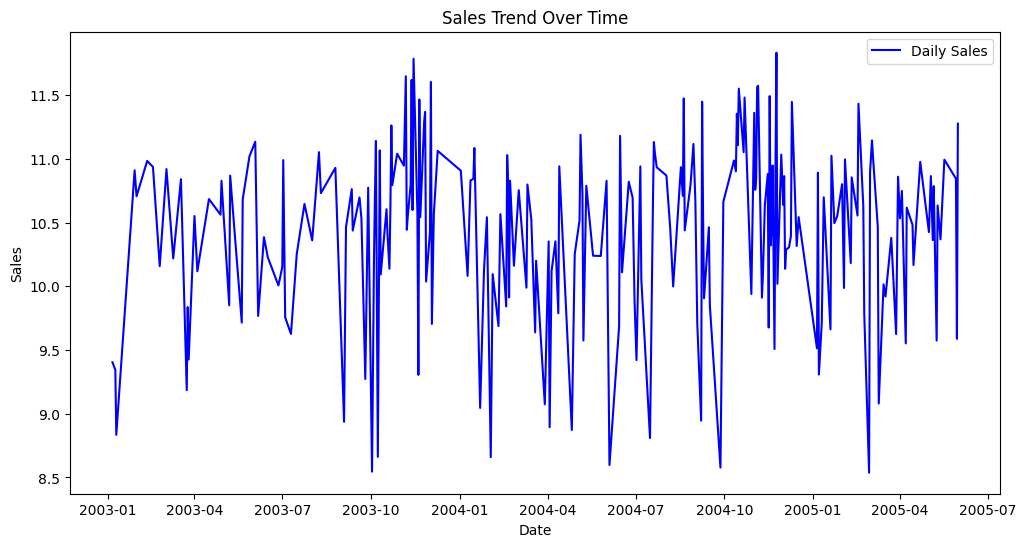

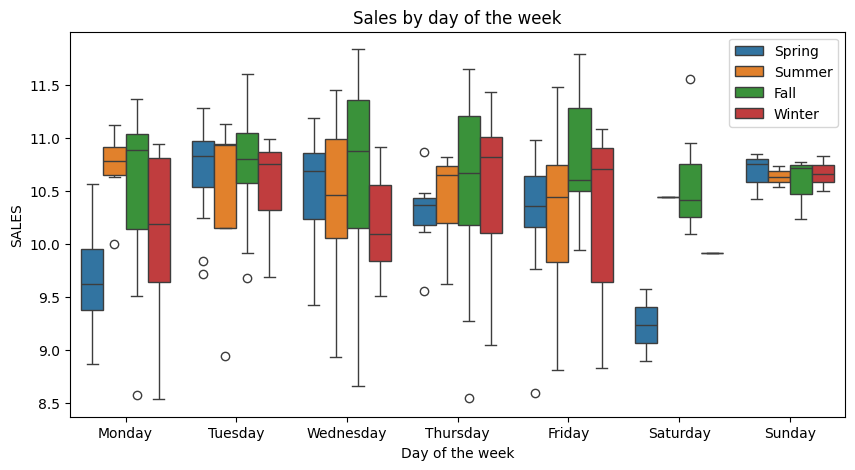

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbg986_l9/m92sr_xg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpbg986_l9/fw6novfo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92917', 'data', 'file=/tmp/tmpbg986_l9/m92sr_xg.json', 'init=/tmp/tmpbg986_l9/fw6novfo.json', 'output', 'file=/tmp/tmpbg986_l9/prophet_modelrb_hlwqc/prophet_model-20250316193314.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:33:14 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:33:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


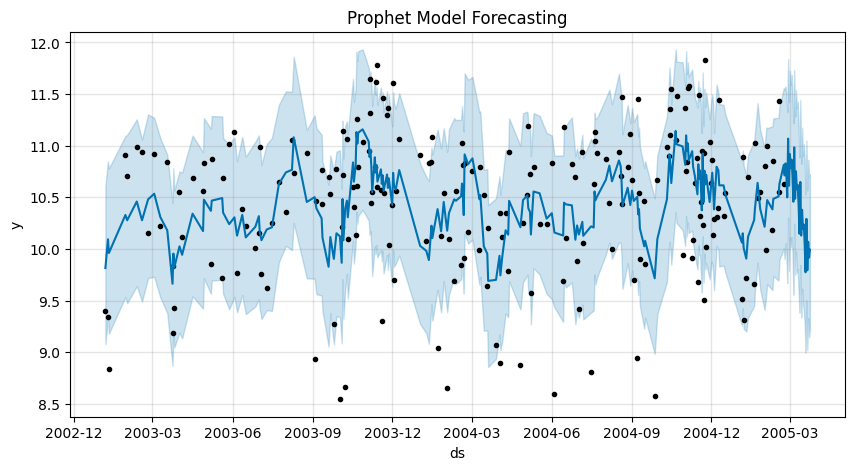

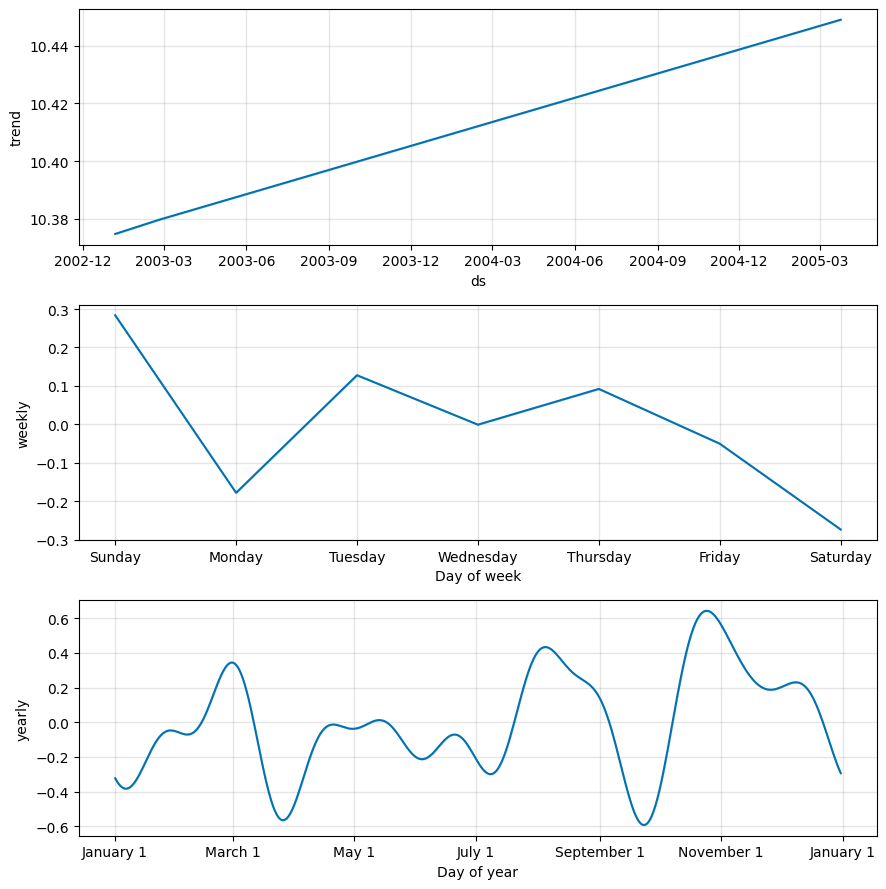

RMSE:0.792724260584282, MAE:0.5685192942092205,MAPE:5.721456834679205


In [3]:
# Import necessary libraries
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import CategoricalDtype

# Define MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Load data
df = pd.read_csv('/sales_data_sample.csv', encoding='latin1')

# Check for missing values
df.isnull().sum()

# Drop unnecessary columns if they exist
cols_to_drop = ['ADDRESSLINE2', 'STATE', 'POSTALCODE', 'TERRITORY']
existing_cols_to_drop = [col for col in cols_to_drop if col in df.columns]
if existing_cols_to_drop:
    df = df.drop(existing_cols_to_drop, axis=1)

# Convert 'ORDERDATE' to datetime if it exists
if 'ORDERDATE' in df.columns:
    df['ORDERDATE'] = pd.to_datetime(df['ORDERDATE'])
else:
    print("Column 'ORDERDATE' does not exist in the DataFrame")

# Aggregate sales by order date and log-transform the sales
df = df.groupby('ORDERDATE')['SALES'].sum().reset_index()
df['SALES'] = np.log(df['SALES'])
df.columns = ['ds', 'y']
df.set_index('ds', inplace=True)

# Handle outliers using the IQR method
Q1 = df['y'].quantile(0.25)
Q3 = df['y'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['y'] >= Q1 - 1.5 * IQR) & (df['y'] <= Q3 + 1.5 * IQR)]

# Visualize sales trends over time
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['y'], label='Daily Sales', color='blue')
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Sales Trend Over Time")
plt.legend()
plt.show()

# Define the categorical type for weekdays with an ordered sequence
cat_type = CategoricalDtype(categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], ordered=True)

# Function to create time series features
def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name().astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320) % 1300
    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], labels=['Spring', 'Summer', 'Fall', 'Winter'])

    X = df[['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'weekday', 'season']]

    if label:
        y = df[label]
        return X, y

    return X

# Create features and target variable
X, y = create_features(df, label='y')

# Concatenate features and target into a single DataFrame
features_and_target = pd.concat([X, y], axis=1)

# Create a box plot to visualize sales distribution by day of the week and season
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target, x='weekday', y='y', hue='season', ax=ax, linewidth=1)
ax.set_title('Sales by day of the week')
ax.set_xlabel('Day of the week')
ax.set_ylabel('SALES')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

# Split the data into training and test sets
df_train = df.iloc[:-30]  # Use all but the last 30 days for training
df_test = df.iloc[-30:]   # Last 30 days as test set

# Initialize and fit the Prophet model
model = Prophet()

# Prepare data for Prophet
df_train.reset_index(inplace=True)
df_train.columns = ['ds', 'y']
df_test.reset_index(inplace=True)
df_test.columns = ['ds', 'y']

# Fit the model
model.fit(df_train)

# Predict using a future dataframe
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Extract test period predictions
df_test_forecast = forecast.iloc[-30:]

# Plot the forecast
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(forecast, ax=ax)
ax.set_title('Prophet Model Forecasting')
plt.show()

# Show seasonal trends
fig = model.plot_components(forecast)
plt.show()

# Evaluate model performance
rmse = np.sqrt(mean_squared_error(df_test['y'], df_test_forecast['yhat']))
mae = mean_absolute_error(df_test['y'], df_test_forecast['yhat'])
mape = mean_absolute_percentage_error(df_test['y'], df_test_forecast['yhat'])

# Display evaluation metrics
print(f'RMSE:{rmse}, MAE:{mae},MAPE:{mape}')

## RESULTS
### Overall Model Forecast Graph:
- What it shows: The model shows actual values(black dots) and the predicted values(blue dots) as well as the shaded are representing the confidence intervals.

  - Interpretation: The model seems to capture the general trend of the data, but there are some deviations where the actual data points fall outside the uncertainty interval. This might suggest that there are some factors influencing the data that the model hasn't fully captured

### Trend Graph:

- What it shows: This graph displays the overall long-term trend in the data. It captures the general direction of the data over time.
  - Interpretation: The trend is steadily increasing over the period from late 2002 to early 2005. This suggests that the sales value has a consistent upward movement.

### Weekly Seasonality Graph:

- What it shows: This graph illustrates the weekly patterns in the data. It shows how the data varies across different days of the week.

  - Interpretation: The graph indicates that there are noticeable weekly fluctuations. For example, there's a peak on Sunday, a dip on Monday, and another peak on Tuesday. Understanding these weekly patterns can be crucial for businesses that experience recurring weekly cycles.

### Yearly Seasonality Graph:

- What it shows: This graph depicts the yearly patterns in the data. It shows how the data changes throughout the year.
  - Interpretation: The graph reveals significant yearly seasonality. There are clear peaks and troughs, suggesting that the data experiences recurring patterns within each year. For instance, there appears to be a major peak around November and a trough around March.